In [99]:
import pandas as pd
import numpy as np
import pycountry
import pycountry_convert as pc


In [100]:
xls = pd.ExcelFile(r"C:\Users\samer\Downloads\Virus_hotlist (2).xlsx")

In [101]:
viruses = ["Adenoviridae", "Anelloviridae", "Arenaviridae", "Arteriviridae", "Astroviridae", "Bornaviridae", "Caliciviridae", "Coronaviridae", "Filoviridae", "Flaviviridae", "Hantaviridae", "Hepadnaviridae", "Hepeviridae", "Herpesviridae", "Nairoviridae", "Orthomyxoviridae", "Papillomaviridae", "Paramyxoviridae", "Parvoviridae", "Peribunyaviridae", "Phenuiviridae", "Picobirnaviridae", "Picornaviridae", "Pneumoviridae", "Polyomaviridae", "Poxviridae", "Reoviridae", "Retroviridae", "Rhabdoviridae", "Togaviridae"]

In [143]:
virus_data = {}

region_to_continent = {
    'asia': 'asia',
    'africa': 'africa',
    'north america': 'americas',
    'oceania': 'oceania',
    'south america': 'americas',
    'northern europe': 'europe',
    'russia': 'europe',
    'northern asia': 'asia',
    'great britain': 'europe',
    'central africa': 'africa',
    'europe': 'europe',
    'papau new guinea': 'oceania',
    'w siberia': 'asia',
    'tuleniy island': 'asia',
    'tropics': 'various',
    'trinidad': 'americas',
    'subtropics': 'various',
    'subsaharan africa': 'africa',
    'south brittany': 'europe',
    'global': 'global',
    'south': 'various',
    'siberia': 'asia',
    'central america': 'americas',
    'americas': 'americas',
    'columbia': 'americas',
    'new guinea': 'oceania',
    'new england': 'americas',
    'micronesia': 'oceania',
    'worldwide': 'global'
}

animal_host_mapping = {
    'rodents': 'rodents',
    'sheep': 'livestock',
    'wild birds': 'birds',
    'waterbirds': 'birds',
    'woodchuck': 'rodents',
    'cotton rat': 'rodents',
    'deer mouse': 'rodents',
    'turkey': 'birds',
    'cattle': 'livestock',
    'humans': 'primates',
    'hares': 'rodents',
    'grouse': 'birds',
    'white-footed mouse': 'rodents',
    'camels': 'livestock',
    'monkeys': 'primates',
    'non-human primates': 'primates',
    'fur seals': 'livestock',
    }

def name_to_continent(name):
    # Handle NaN values and lowercase conversion
    if pd.isnull(name) or name == 'nan':
        return 'Unknown'
    name = name.lower()
    # Check for region or special case mapping
    if name in region_to_continent:
        return region_to_continent[name]
    try:
        # Attempt to resolve country name to continent
        country = pycountry.countries.lookup(name)
        continent_code = pc.country_alpha2_to_continent_code(country.alpha_2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        # Fallback for unresolved names
        return 'Unknown'

def apply_animal_host_mapping(animal):
    if pd.isna(animal):
        return 'unknown'  # Handle NaN values explicitly
    animal = animal.lower().strip()  # Normalize the case and strip any whitespace
    return animal_host_mapping.get(animal, animal)

for virus in viruses:
    df = pd.read_excel(xls, sheet_name=virus)
    # Check if 'Latin name' column exists and filter out citations
    if 'Latin name' in df.columns:
        citation_pattern = r'^\d+\.\s*'
        mask = df['Latin name'].str.match(citation_pattern).fillna(False)
        df = df[~mask]
    # Check if 'Animal host' column exists and remove any bracketed text
    if 'Animal host' in df.columns:
    # Use a more general regex pattern to also match non-numeric characters and multiple values in brackets
        df['Animal host'] = df['Animal host'].astype(str).str.replace(r'\s*\[.*?\]', '', regex=True)
    # Replace and with comma
        df['Animal host'] = df['Animal host'].astype(str).replace(' and ', ', ', regex=True)
    # Remove question marks
        df['Animal host'] = df['Animal host'].str.replace(r'\?$', '', regex=True)
    # Split the string on commas
        df['Animal host'] = df['Animal host'].str.split(', ')
    # Explode the list of animal hosts into separate rows
        df = df.explode('Animal host')
    # Map animal hosts to broader categories
        df['Animal host'] = df['Animal host'].apply(apply_animal_host_mapping)


    if 'Geographical Range' in df.columns:
    # Remove any bracketed text
        df['Geographical Range'] = df['Geographical Range'].astype(str).str.replace(r'\s*\[.*?\]', '', regex=True)
    # Replace USA with united states
        df['Geographical Range'] = df['Geographical Range'].replace('USA', 'united states', regex=True)
    # Replace and with comma
        df['Geographical Range'] = df['Geographical Range'].astype(str).replace(' and ', ', ', regex=True)
    # Split the string on commas
        df['Geographical Range'] = df['Geographical Range'].str.split(', ')
    # Explode the list of geographical ranges into separate rows
        df = df.explode('Geographical Range')
    # Convert geographical range to continent
        df['Continent'] = df['Geographical Range'].apply(lambda x: name_to_continent(x) if pd.notna(x) else 'unknown')

        df['Continent'] = df['Continent'].str.lower()  # Ensure lowercase for consistency
        df.loc[df['Continent'].isin(['north america', 'south america']), 'Continent'] = 'americas'


    # Check if the virus key exists in virus_data dictionary
    if virus not in virus_data:
        virus_data[virus] = {}

    # Convert all string columns to lowercase
    for col in df.select_dtypes(include=[object]).columns:
        df[col] = df[col].str.lower()


    virus_data[virus] = df

In [144]:
virus_data['Flaviviridae'].groupby('Geographical Range').size().sort_values(ascending=False)


Geographical Range
nan                         11
malaysia                     7
australia                    7
united states                7
africa                       7
senegal                      6
uganda                       5
northern europe              5
central african republic     5
brazil                       4
saudi arabia                 4
thailand                     3
great britain                3
russia                       3
papau new guinea             3
cameroon                     3
nigeria                      3
asia                         3
northern asia                3
south africa                 2
madagascar                   2
japan                        2
mongolia                     2
tuleniy island               2
canada                       2
south                        1
south america                1
siberia                      1
south brittany               1
subsaharan africa            1
subtropics                   1
taiwan              

In [145]:
virus_data['Flaviviridae'].groupby('Continent').size().sort_values(ascending=False)

Continent
africa      36
asia        36
americas    24
europe      14
oceania     12
unknown     12
various      3
global       2
dtype: int64

In [146]:
print(virus_data['Flaviviridae'].groupby('Animal host').size().sort_values(ascending=False))

Animal host
birds         32
rodents       32
bats          22
nan           13
livestock     11
primates      11
unknown        9
marsupials     5
cervids        2
ticks          2
dtype: int64


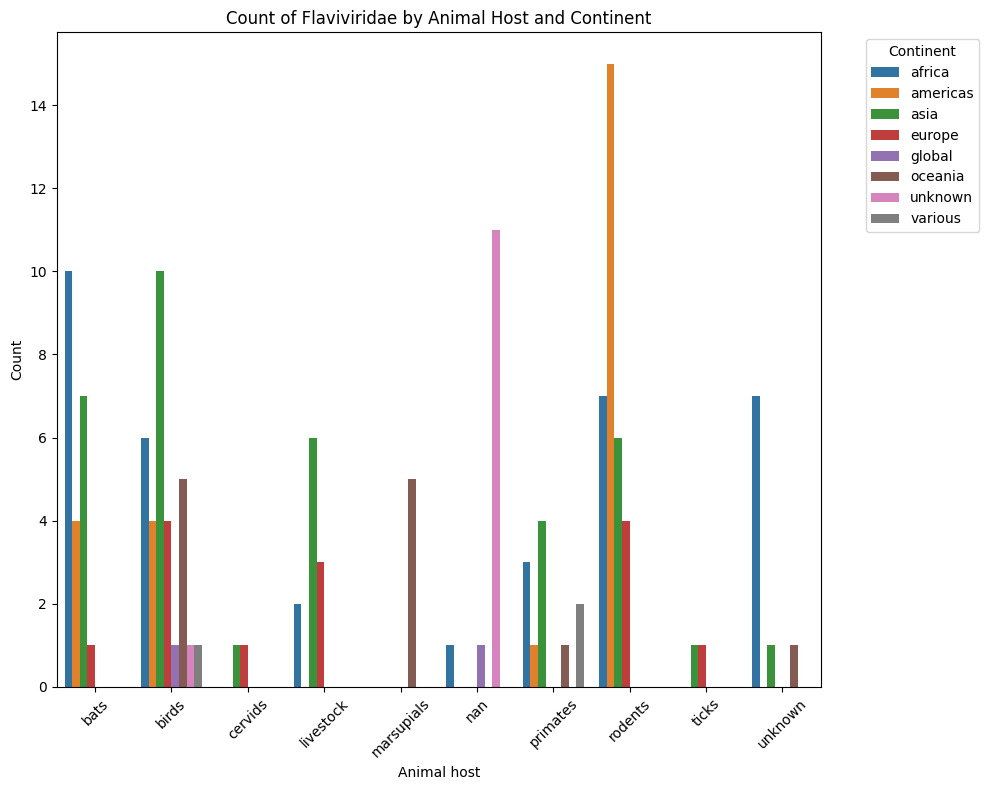

In [147]:
import matplotlib.pyplot as plt
virus_crosstab = pd.crosstab(virus_data['Flaviviridae']['Animal host'], virus_data['Flaviviridae']['Continent'])

# Melt the crosstabbed DataFrame to have 'Continent', 'Animal host', and 'Count' columns
virus_melted = virus_crosstab.reset_index().melt(id_vars='Animal host', var_name='Continent', value_name='Count')

# Now plot with seaborn
plt.figure(figsize=(10,8))
sns.barplot(x='Animal host', y='Count', hue='Continent', data=virus_melted)

# Improve Aesthetics
plt.xticks(rotation=45) # Rotate x-axis labels for better visibility if needed
plt.title('Count of Flaviviridae by Animal Host and Continent')
plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc=2) # Move the legend out of the plot

# Show the plot
plt.tight_layout()
plt.show()

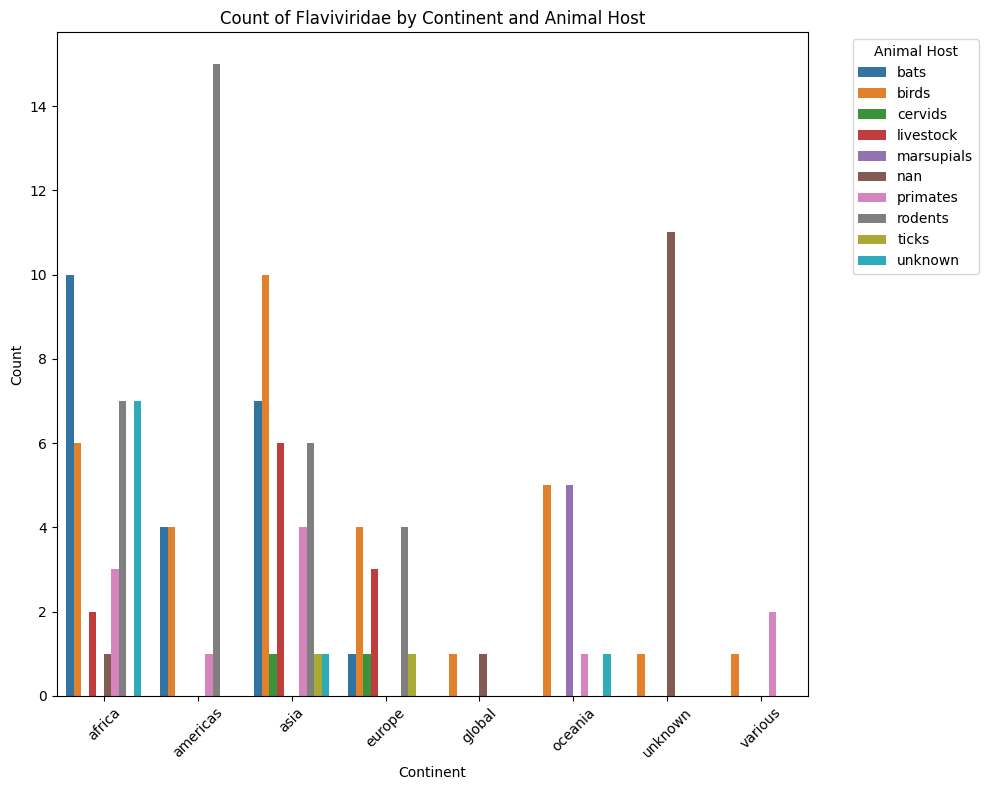

In [148]:
plt.figure(figsize=(10,8))
sns.barplot(x='Continent', y='Count', hue='Animal host', data=virus_melted,)

# Improve Aesthetics
plt.xticks(rotation=45) # Adjust rotation for better label readability if needed
plt.title('Count of Flaviviridae by Continent and Animal Host')
plt.legend(title='Animal Host', bbox_to_anchor=(1.05, 1), loc=2) # Move the legend out of the plot

# Show the plot
plt.tight_layout()
plt.show()

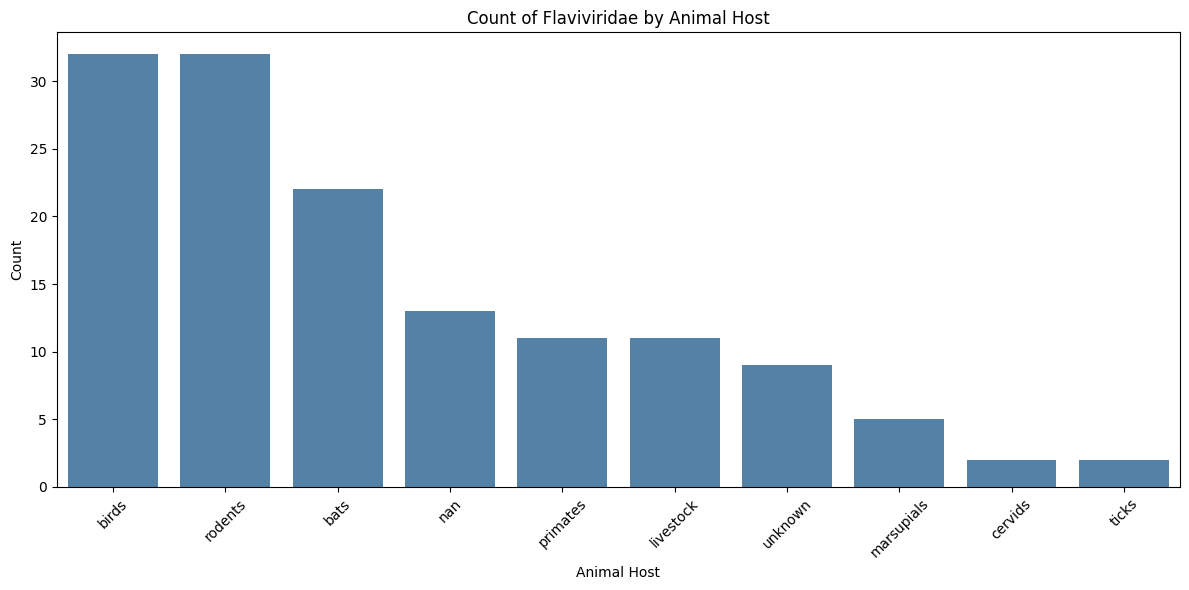

In [149]:
plt.figure(figsize=(12, 6))
sns.countplot(data=virus_data['Flaviviridae'], x='Animal host', order=virus_data['Flaviviridae']['Animal host'].value_counts().index, color='steelblue')
plt.xticks(rotation=45)
plt.xlabel('Animal Host')
plt.ylabel('Count')
plt.title('Count of Flaviviridae by Animal Host')
plt.tight_layout()
plt.show()

Can you send us the first two graphs as they are
1. Visualization of second graph with updated table info
2. Graph of animal hosts alone
3. Graph of animal hosts with vector groupings

In [126]:
# Assuming virus_data['Flaviviridae'] is correctly defined and cleaned as above
df = virus_data['Flaviviridae']

In [127]:
# Assuming virus_data['Flaviviridae'] is your DataFrame

# Clean the 'Mode of Transmission' column
virus_data['Flaviviridae']['Mode of Transmission'] = (
    virus_data['Flaviviridae']['Mode of Transmission']
    .astype(str)
    .str.replace(r"\(.*?\)|\s*\[.*?\]", "", regex=True)  # Remove text within parentheses/brackets
    .str.strip()  # Remove any leading/trailing whitespace
    .str.lower()  # Convert to lowercase
)

# Confirm cleaning
print(virus_data['Flaviviridae']['Mode of Transmission'].unique())

['tickborne' 'mosquitoborne' 'unknown' 'nan' 'blood exposure']


In [138]:
import pandas as pd
import plotly.graph_objects as go

# Create a frequency table for 'Animal host' and 'Mode of Transmission'
frequency_table = df.groupby(['Animal host', 'Mode of Transmission']).size().reset_index(name='Count')

mode_colors = {
    'mosquitoborne': 'blue',
    'tickborne': 'green',
    'unknown': 'grey',
    'nan': 'black',
    'blood-exposure': 'red'
}

# Create lists of unique 'Animal hosts' and 'Mode of Transmission'
animal_hosts = frequency_table['Animal host'].unique().tolist()
modes_of_transmission = frequency_table['Mode of Transmission'].unique().tolist()

# Initialize lists to hold our sources, targets, and values for the Sankey diagram
sources = []
targets = []
values = []

link_color_list = []

# Fill in the link colors based on 'Mode of Transmission'
for _, row in frequency_table.iterrows():
    # Use the mode to get the corresponding color, default to black if not found
    link_color_list.append(mode_colors.get(row['Mode of Transmission'], 'black'))

# Create a Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=10,
      line=dict(color="black", width=0.5),
      label=animal_hosts + modes_of_transmission,
    ),
    link=dict(
      source=[animal_hosts.index(src) for src in frequency_table['Animal host']],
      target=[len(animal_hosts) + modes_of_transmission.index(tgt) for tgt in frequency_table['Mode of Transmission']],
      value=frequency_table['Count'].tolist(),
      color=link_color_list,
    ))])

fig.update_layout(title_text="Sankey Diagram of Animal Hosts and Mode of Transmission", font_size=10)
fig.show()



In [150]:
# Assuming virus_data['Flaviviridae'] is your cleaned DataFrame
virus_data['Flaviviridae'].to_csv('cleaned_data.csv', index=False)
